In [96]:
!pip install missingno seaborn scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

In [97]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d toramky/automobile-dataset


!unzip automobile-dataset.zip

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/toramky/automobile-dataset
License(s): unknown
automobile-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  automobile-dataset.zip
replace Automobile_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Automobile_data.csv     


In [98]:
df=pd.read_csv("Automobile_data.csv")

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [100]:
print(df.isnull().sum()) #not identfying '?'

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64


In [101]:
df.replace("?", np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')  # Convert valid numerics


/tmp/ipython-input-101-3702331185.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')  # Convert valid numerics


In [102]:
df.isnull().sum().sort_values(ascending=False)


,0
normalized-losses,41
stroke,4
price,4
bore,4
horsepower,2
peak-rpm,2
num-of-doors,2
symboling,0
fuel-type,0
make,0


In [103]:
df['normalized-losses'] = df['normalized-losses'].replace('?', np.nan)

df['normalized-losses'] = pd.to_numeric(df['normalized-losses'], errors='coerce')

In [104]:
print(df['normalized-losses'].value_counts())


normalized-losses
161.0    11
91.0      8
150.0     7
128.0     6
104.0     6
134.0     6
74.0      5
103.0     5
168.0     5
95.0      5
102.0     5
94.0      5
65.0      5
85.0      5
93.0      4
106.0     4
118.0     4
122.0     4
148.0     4
154.0     3
83.0      3
125.0     3
115.0     3
137.0     3
101.0     3
194.0     2
197.0     2
188.0     2
164.0     2
158.0     2
192.0     2
110.0     2
145.0     2
113.0     2
81.0      2
89.0      2
87.0      2
108.0     2
119.0     2
153.0     2
129.0     2
98.0      1
121.0     1
107.0     1
78.0      1
231.0     1
142.0     1
77.0      1
186.0     1
90.0      1
256.0     1
Name: count, dtype: int64


In [105]:
#we identify 41 missing values - now whether to handle them w mean/'mode or truncate them at all - first we detect the outliers and their plausible effect on same
missing_mask = df['normalized-losses'].isnull()
print("Number of missing values:", missing_mask.sum())  # Should be > 0 now


Number of missing values: 41


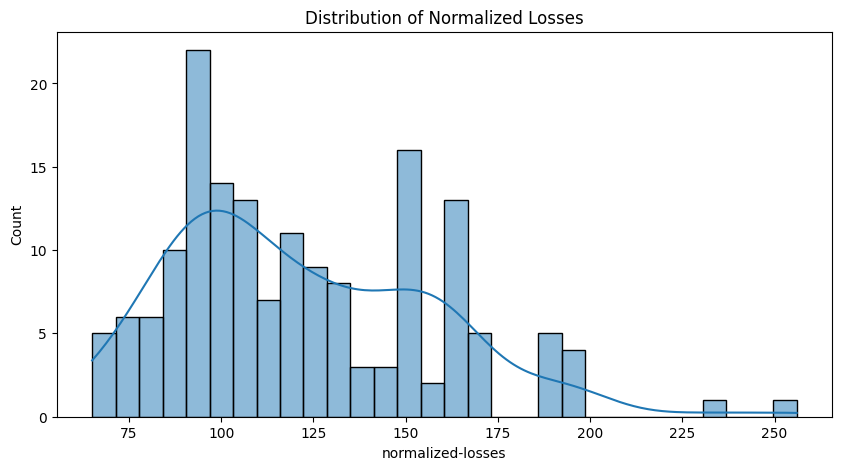

In [107]:
#checking distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['normalized-losses'], kde=True, bins=30)
plt.title("Distribution of Normalized Losses")
plt.show()

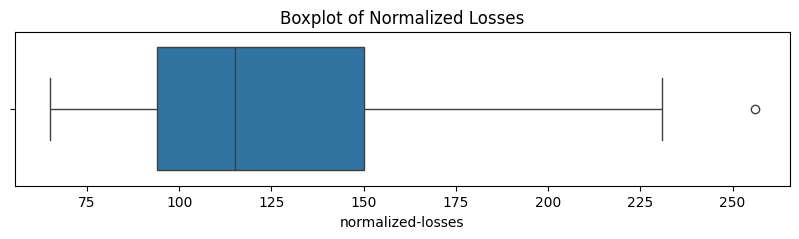

In [108]:
#boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['normalized-losses'])
plt.title("Boxplot of Normalized Losses")
plt.show()

In [109]:
#IQR Method
Q1 = df['normalized-losses'].quantile(0.25)
Q3 = df['normalized-losses'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['normalized-losses'] < lower_bound) | (df['normalized-losses'] > upper_bound)]
print("Number of outliers in normalized-losses:", len(outliers))
print(outliers[['normalized-losses']].head())


Number of outliers in normalized-losses: 1
     normalized-losses
190              256.0


In [110]:
#skewness overall - only 1 outlier detected
from scipy.stats import skew

print("Skewness:", df['normalized-losses'].skew())


Skewness: 0.7659764175950632


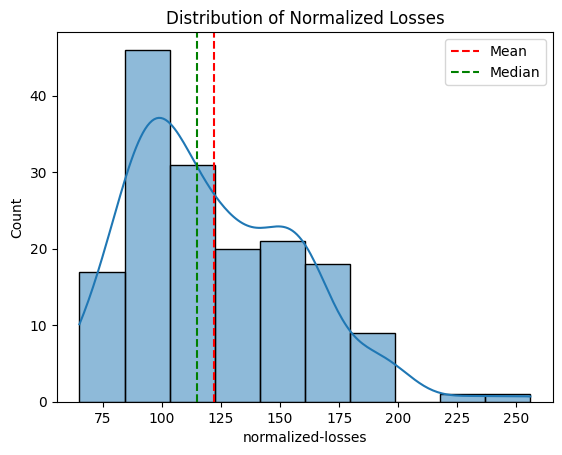

In [111]:
sns.histplot(df['normalized-losses'], kde=True)
plt.axvline(df['normalized-losses'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df['normalized-losses'].median(), color='green', linestyle='--', label='Median')
plt.title('Distribution of Normalized Losses')
plt.legend()
plt.show()


In [112]:
# Correlation check to check what is affecting this column
print(df.corr(numeric_only=True)['normalized-losses'].sort_values(ascending=False))

# Grouped mean
df.groupby('make')['normalized-losses'].mean().sort_values(ascending=False).head(10)


normalized-losses    1.000000
symboling            0.528667
horsepower           0.295772
peak-rpm             0.264597
price                0.203254
engine-size          0.167365
curb-weight          0.119893
width                0.105073
stroke               0.065627
length               0.023220
bore                -0.036167
wheel-base          -0.074362
compression-ratio   -0.132654
highway-mpg         -0.210768
city-mpg            -0.258502
height              -0.432335
Name: normalized-losses, dtype: float64


,normalized-losses
make,
bmw,190.000000
porsche,186.000000
audi,161.000000
peugot,161.000000
mitsubishi,146.200000
jaguar,145.000000
nissan,135.166667
dodge,133.444444
plymouth,129.000000


In [113]:
#this helps us conclude that symboling has the strongest correlation with randomised losses , followed by horsepower, peak-rpm and price .
#city mpg, height etc are negative and so no correlation

#the grouping by make shows luxury brands like mbw, porsche, audi and peugot have higher normalized_losses

In [114]:
features = ['symboling', 'horsepower', 'peak-rpm', 'price', 'engine-size', 'curb-weight', 'width', 'make']


In [115]:
from sklearn.preprocessing import OneHotEncoder

df_encoded = pd.get_dummies(df[features])


In [116]:
known = df[df['normalized-losses'].notnull()]
unknown = df[df['normalized-losses'].isnull()]

In [117]:
from sklearn.ensemble import RandomForestRegressor

X_train = pd.get_dummies(known[features])
y_train = known['normalized-losses']

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [118]:
missing_mask = df['normalized-losses'].isnull()
print("Number of missing values:", missing_mask.sum())
print("Length of predicted values:", len(predicted_losses))

Number of missing values: 41
Length of predicted values: 41


In [119]:
X_unknown = pd.get_dummies(unknown[features])
X_unknown = X_unknown.reindex(columns=X_train.columns, fill_value=0)

predicted_losses = model.predict(X_unknown)
df.loc[df['normalized-losses'].isnull(), 'normalized-losses'] = predicted_losses

In [120]:
print("Predicted shape:", predicted_losses.shape)
print("Missing values in normalized-losses:", df['normalized-losses'].isnull().sum())

Predicted shape: (41,)
Missing values in normalized-losses: 0


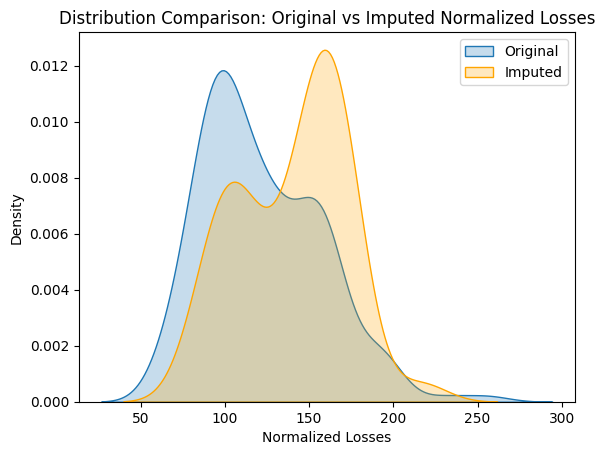

In [121]:
# Before imputation (dropna)
original_vals = df.loc[~missing_mask, 'normalized-losses'].astype(float)
# After imputation (predicted)
imputed_vals = df.loc[missing_mask, 'normalized-losses'].astype(float)

sns.kdeplot(original_vals, label='Original', fill=True)
sns.kdeplot(imputed_vals, label='Imputed', fill=True, color='orange')
plt.title('Distribution Comparison: Original vs Imputed Normalized Losses')
plt.xlabel('Normalized Losses')
plt.legend()
plt.show()


In [122]:
from scipy.stats import skew
print("Skewness after imputation:", skew(df['normalized-losses'].astype(float)))


Skewness after imputation: 0.5545877258938626


--- stroke ---
Skewness: -0.70
Number of outliers: 20


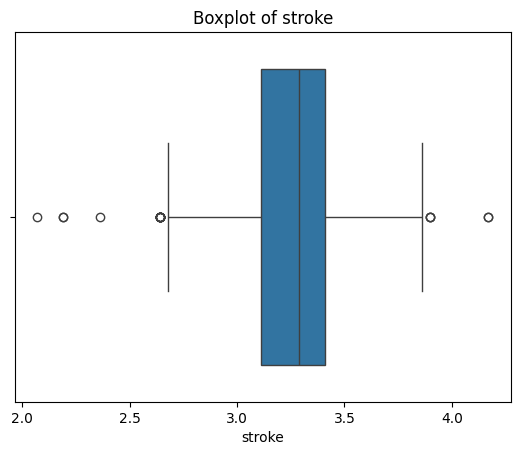

--- bore ---
Skewness: 0.02
Number of outliers: 0


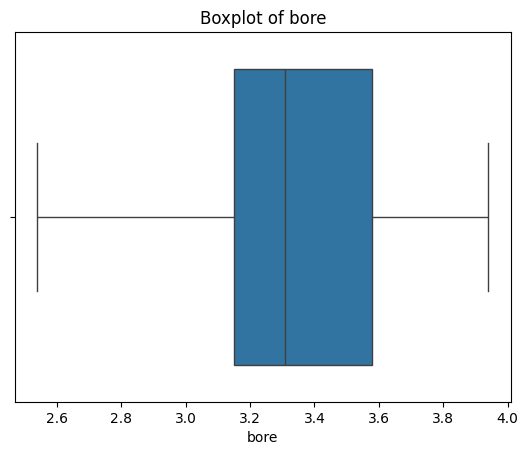

--- horsepower ---
Skewness: 0.49
Number of outliers: 2


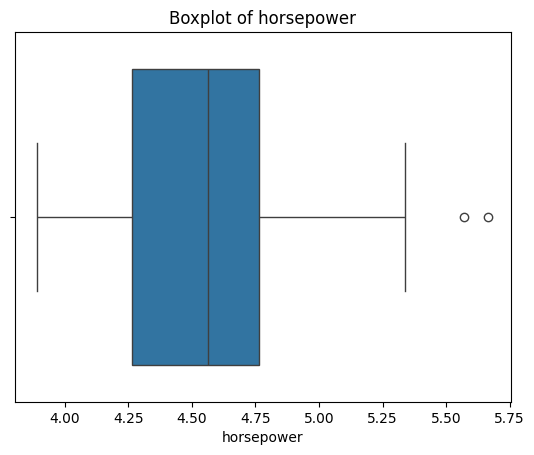

--- peak-rpm ---
Skewness: 0.07
Number of outliers: 2


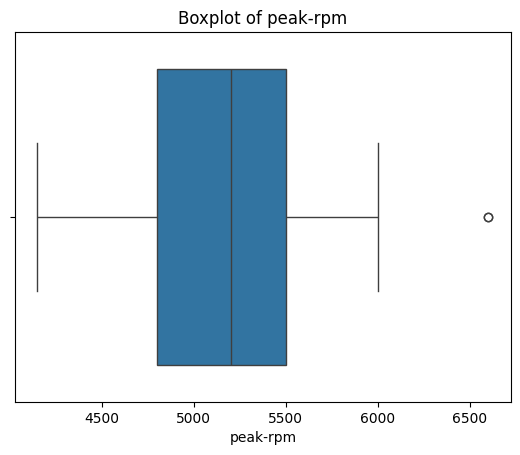

--- curb-weight ---
Skewness: 0.68
Number of outliers: 0


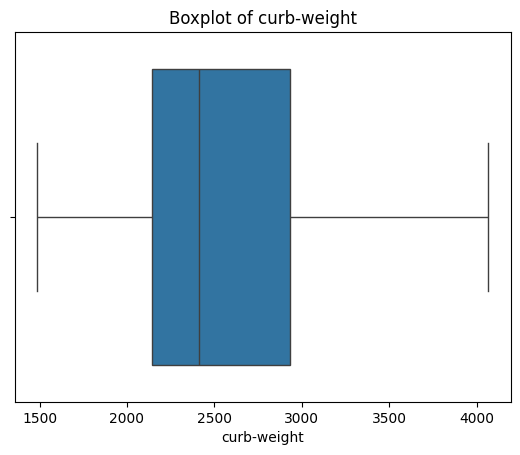

In [152]:
#now for other columns
columns_to_check = ['stroke', 'bore', 'horsepower', 'peak-rpm' , 'curb-weight']
for col in columns_to_check:
    print(f"--- {col} ---")
    df[col] = pd.to_numeric(df[col], errors='coerce')
    col_skew = df[col].skew()
    print(f"Skewness: {col_skew:.2f}")

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"Number of outliers: {outliers.shape[0]}")

    # Visualization
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [124]:
#from above we can infer :
# stroke - left skew - 20 outliers
# bore - no skew - no outlier
# horsepower - highly skewed - 6 outliers
# peak-rpm - less skewed - right - outlier : 2

In [125]:
df_before = pd.read_csv('Automobile_data.csv')
df_before.replace('?', np.nan, inplace=True)

# Convert relevant columns to numeric
cols_to_convert = ['stroke', 'bore', 'horsepower', 'peak-rpm']
for col in cols_to_convert:
    df_before[col] = pd.to_numeric(df_before[col], errors='coerce')


In [127]:
# Ensure numeric conversion
for col in ['stroke', 'bore', 'horsepower', 'peak-rpm']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute based on skewness and outliers
df['stroke'].fillna(df['stroke'].median())
df['bore'].fillna(df['bore'].mean())
df['horsepower'].fillna(df['horsepower'].median())
df['peak-rpm'].fillna(df['peak-rpm'].median())


,peak-rpm
0,5000.0
1,5000.0
2,5000.0
3,5500.0
4,5500.0
...,...
200,5400.0
201,5300.0
202,5500.0
203,4800.0


In [128]:
mode_val = df['num-of-doors'].mode()[0]
df['num-of-doors'].fillna(mode_val)


,num-of-doors
0,two
1,two
2,two
3,four
4,four
...,...
200,four
201,four
202,four
203,four


In [129]:

print("Skewness after imputation:", skew(df['stroke'].astype(float)))
print("Skewness after imputation:", skew(df['bore'].astype(float)))
print("Skewness after imputation:", skew(df['horsepower'].astype(float)))
print("Skewness after imputation:", skew(df['peak-rpm'].astype(float)))

Skewness after imputation: -0.6909297881265289
Skewness after imputation: 0.020062526293150085
Skewness after imputation: 1.3931510049522813
Skewness after imputation: 0.06847310590040785


In [130]:
# List of target columns
target_cols = ['stroke', 'bore', 'horsepower', 'peak-rpm', 'price', 'num-of-doors']

# Check for nulls in those columns
null_check = df[target_cols].isnull().sum()

print("Null values after imputation:")
print(null_check)


Null values after imputation:
stroke          0
bore            0
horsepower      0
peak-rpm        0
price           4
num-of-doors    2
dtype: int64


In [131]:
from scipy.stats import skew

# Helper to print skewness for selected columns
def compare_skewness(df_before, df_after, columns):
    print(f"{'Column':<15}{'Before':>15}{'After':>15}")
    print("-" * 45)
    for col in columns:
        skew_before = skew(df_before[col].dropna().astype(float))
        skew_after = skew(df_after[col].astype(float))
        print(f"{col:<15}{skew_before:>15.4f}{skew_after:>15.4f}")

# Run comparison
compare_skewness(df_before, df, ['stroke', 'bore', 'horsepower', 'peak-rpm'])


Column                  Before          After
---------------------------------------------
stroke                 -0.6780        -0.6909
bore                    0.0199         0.0201
horsepower              1.3807         1.3932
peak-rpm                0.0727         0.0685


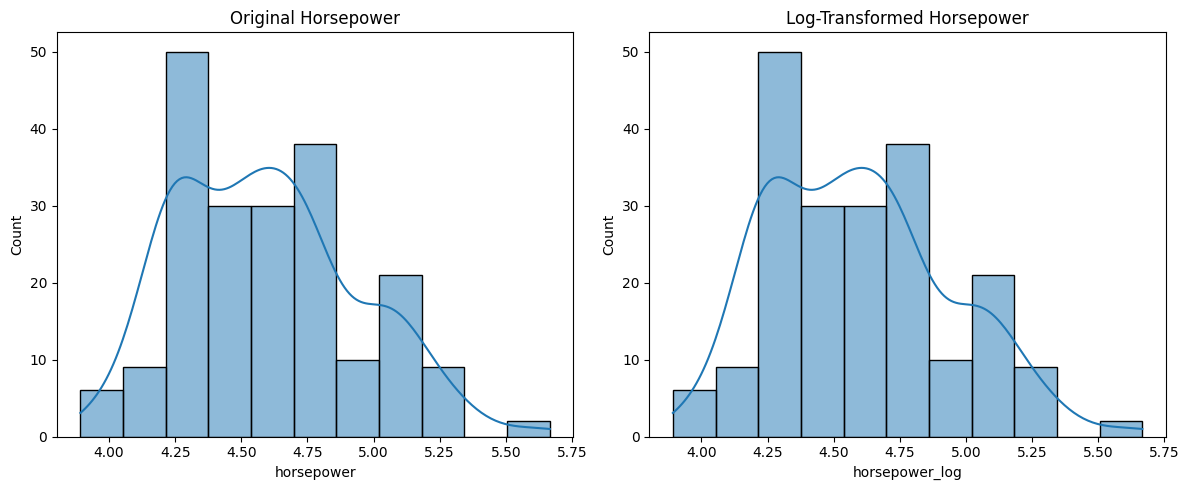

New skewness (log horsepower): 0.4822575324379495


In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log1p (log(1 + x)) to handle zeros gracefully
df['horsepower'] = np.log1p(df['horsepower'].astype(float))

# Plot to visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['horsepower'].astype(float), kde=True, ax=axes[0])
axes[0].set_title('Original Horsepower')

sns.histplot(df['horsepower_log'], kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Horsepower')

plt.tight_layout()
plt.show()

# Check new skewness
print("New skewness (log horsepower):", skew(df['horsepower_log'].dropna()))


In [133]:
missing_rows = df[df['price'].isnull()]
print(missing_rows[features].isnull().sum())


symboling      0
horsepower     0
peak-rpm       0
price          4
engine-size    0
curb-weight    0
width          0
make           0
dtype: int64


In [134]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np

# 1. Convert 'price' to numeric (if not already)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 2. Remove rows with missing price for training
price_df = df[df['price'].notnull()].copy()

# 3. Define features for prediction
features = ['engine-size', 'horsepower', 'curb-weight', 'width', 'length']

# Ensure numeric type for all features
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    price_df[col] = pd.to_numeric(price_df[col], errors='coerce')

# Drop rows with missing feature values in training data
price_df = price_df.dropna(subset=features)

# 4. Prepare X and y
X_price = pd.get_dummies(price_df[features])
y_price = price_df['price']

# 5. Train the model
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_price, y_price)

# 6. Prepare data for prediction (rows with missing price)
price_missing = df[df['price'].isnull()].copy()
X_missing = pd.get_dummies(price_missing[features])

# Align columns with training data (important for dummies)
X_missing = X_missing.reindex(columns=X_price.columns, fill_value=0)

# 7. Predict missing prices
predicted_prices = gbr.predict(X_missing)
df.loc[df['price'].isnull(), 'price'] = predicted_prices


In [135]:
print("Missing prices after imputation:", df['price'].isnull().sum())


Missing prices after imputation: 0


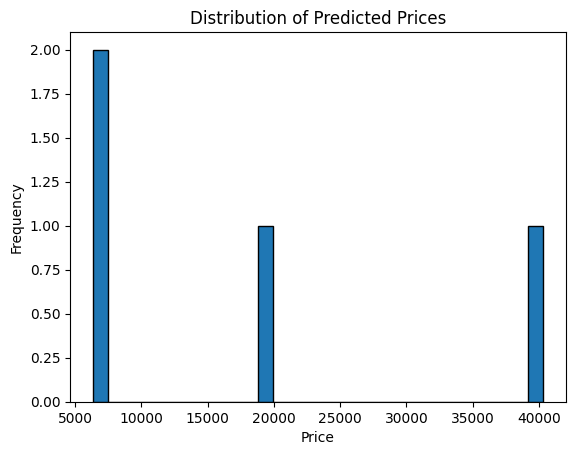

In [136]:
import matplotlib.pyplot as plt

plt.hist(predicted_prices, bins=30, edgecolor='k')
plt.title("Distribution of Predicted Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


In [140]:
from scipy.stats import skew

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Print skewness of each
print("Skewness of Numeric Features:\n")
for col in numeric_cols:
    skew_val = skew(df[col].dropna())
    print(f"{col}: {skew_val:.4f}")


Skewness of Numeric Features:

symboling: 0.2095
normalized-losses: 0.5546
wheel-base: 1.0425
length: 0.1548
width: 0.8974
height: 0.0627
curb-weight: 0.6764
engine-size: 1.9334
bore: 0.0201
stroke: -0.6909
compression-ratio: 2.5917
horsepower: 0.4823
peak-rpm: 0.0685
city-mpg: 0.6588
highway-mpg: 0.5360
price: 1.7866
horsepower_log: 0.4823


In [141]:
df['engine-size'] = np.log1p(df['engine-size'])
df['compression-ratio'] = np.log1p(df['compression-ratio'])
df['price'] = np.log1p(df['price'])
df['wheel-base'] = np.log1p(df['wheel-base'])  # optional


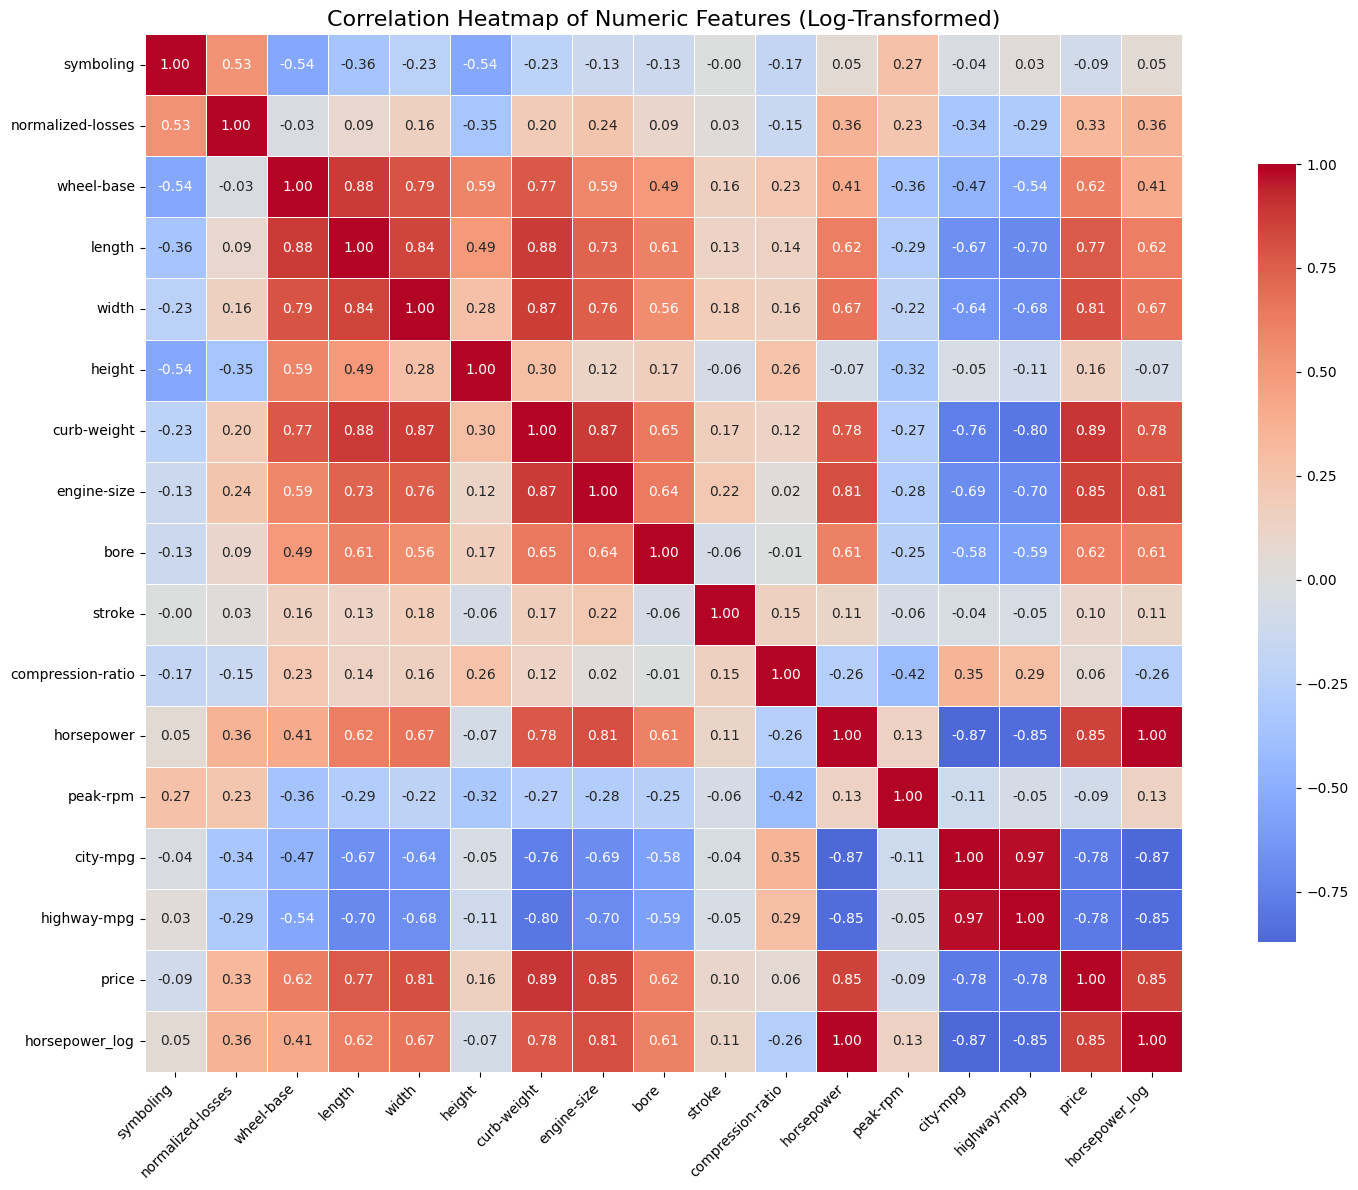

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix
corr_matrix = df[numeric_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .75})

plt.title("Correlation Heatmap of Numeric Features (Log-Transformed)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipython-input-143-3553181860.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


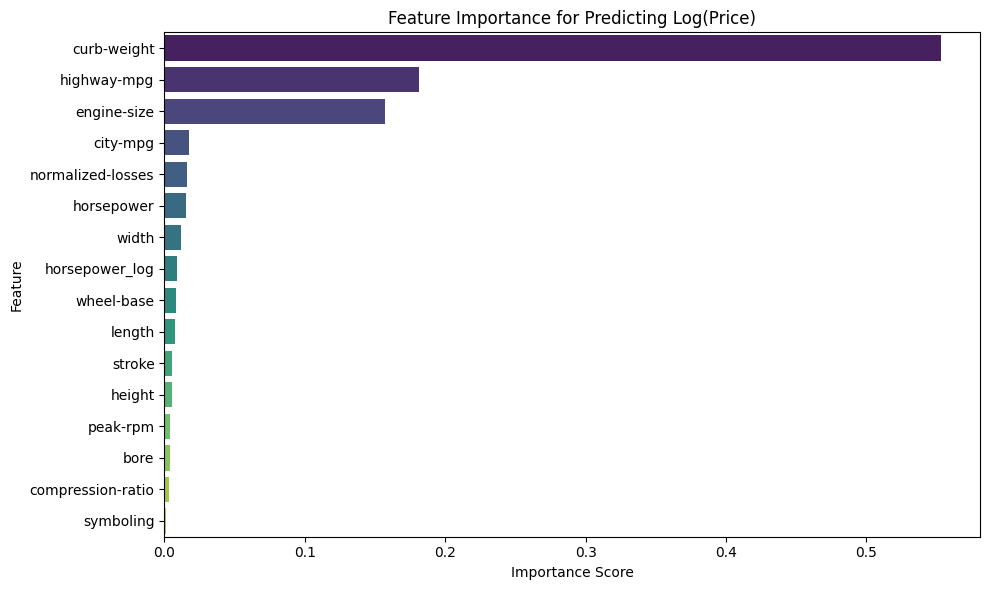

In [143]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Select numerical features only
numeric_cols = df.select_dtypes(include='number').columns.tolist()
target = 'price'  # Make sure it's the log-transformed version

# Step 2: Prepare X and y
X = df[numeric_cols].drop(columns=['price'])  # Drop target
y = df['price']  # Log-transformed price

# Step 3: Handle missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 4: Train RandomForest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_imputed, y)

# Step 5: Plot feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Feature Importance for Predicting Log(Price)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


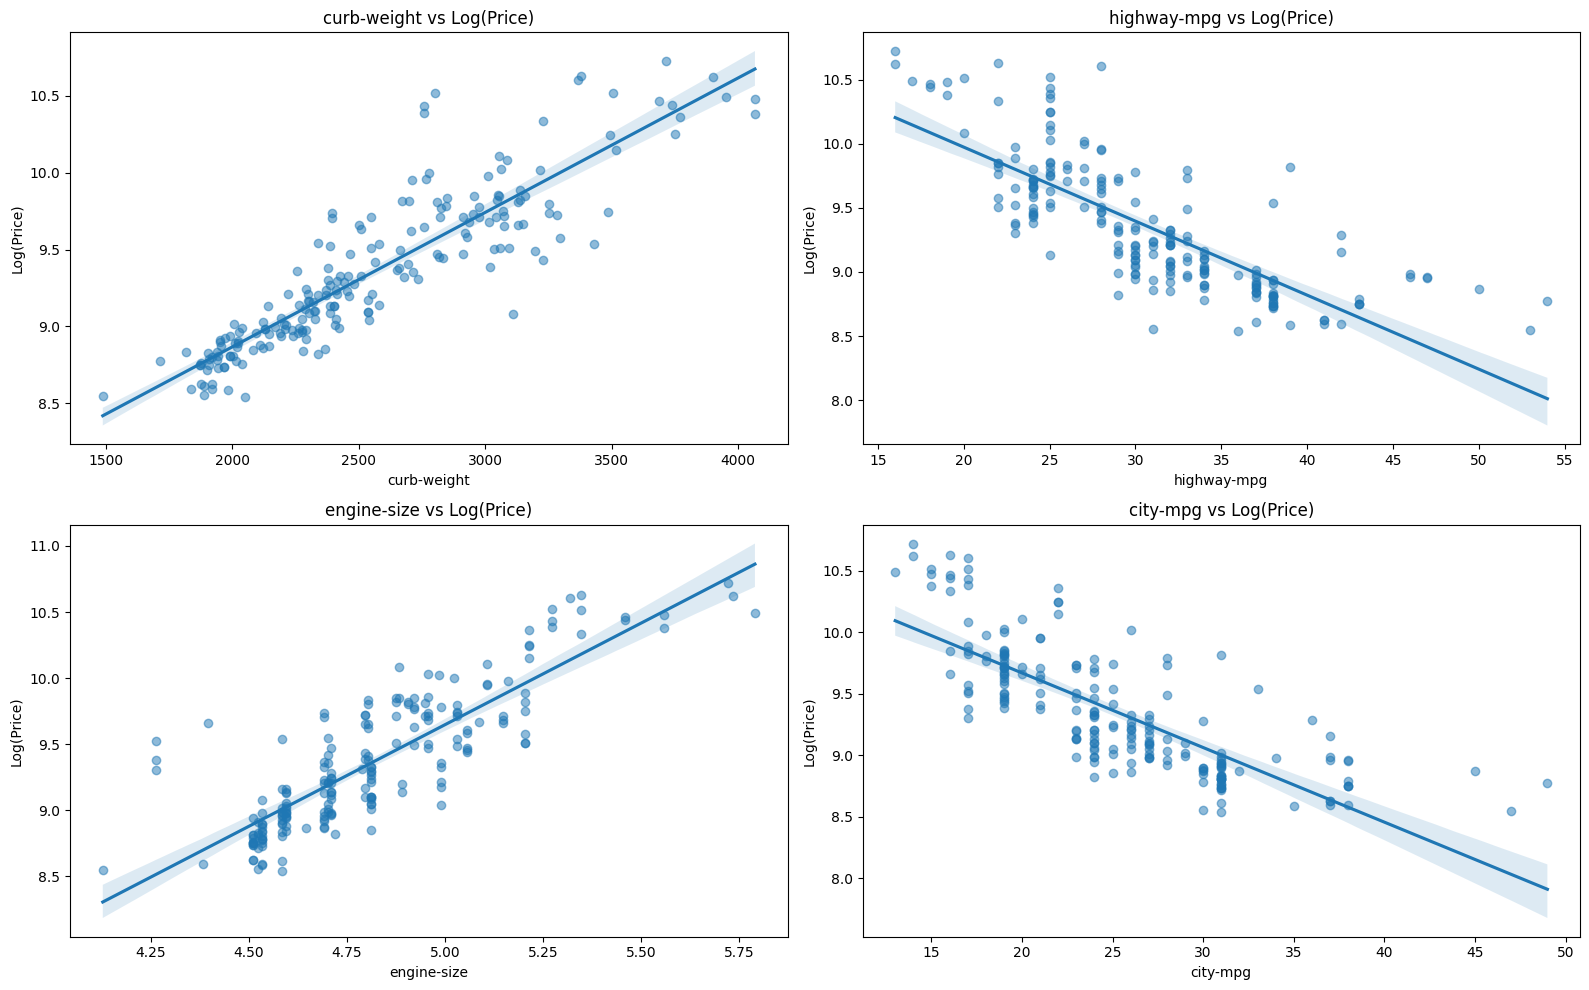

In [145]:
top_features = importances.head(4).index.tolist()

plt.figure(figsize=(16, 10))

for i, feature in enumerate(top_features):
    plt.subplot(2, 2, i + 1)
    # sns.scatterplot(data=df, x=feature, y='price')
    sns.regplot(data=df, x=feature, y='price', scatter_kws={'alpha':0.5})

    plt.title(f'{feature} vs Log(Price)')
    plt.xlabel(feature)
    plt.ylabel('Log(Price)')

plt.tight_layout()
plt.show()


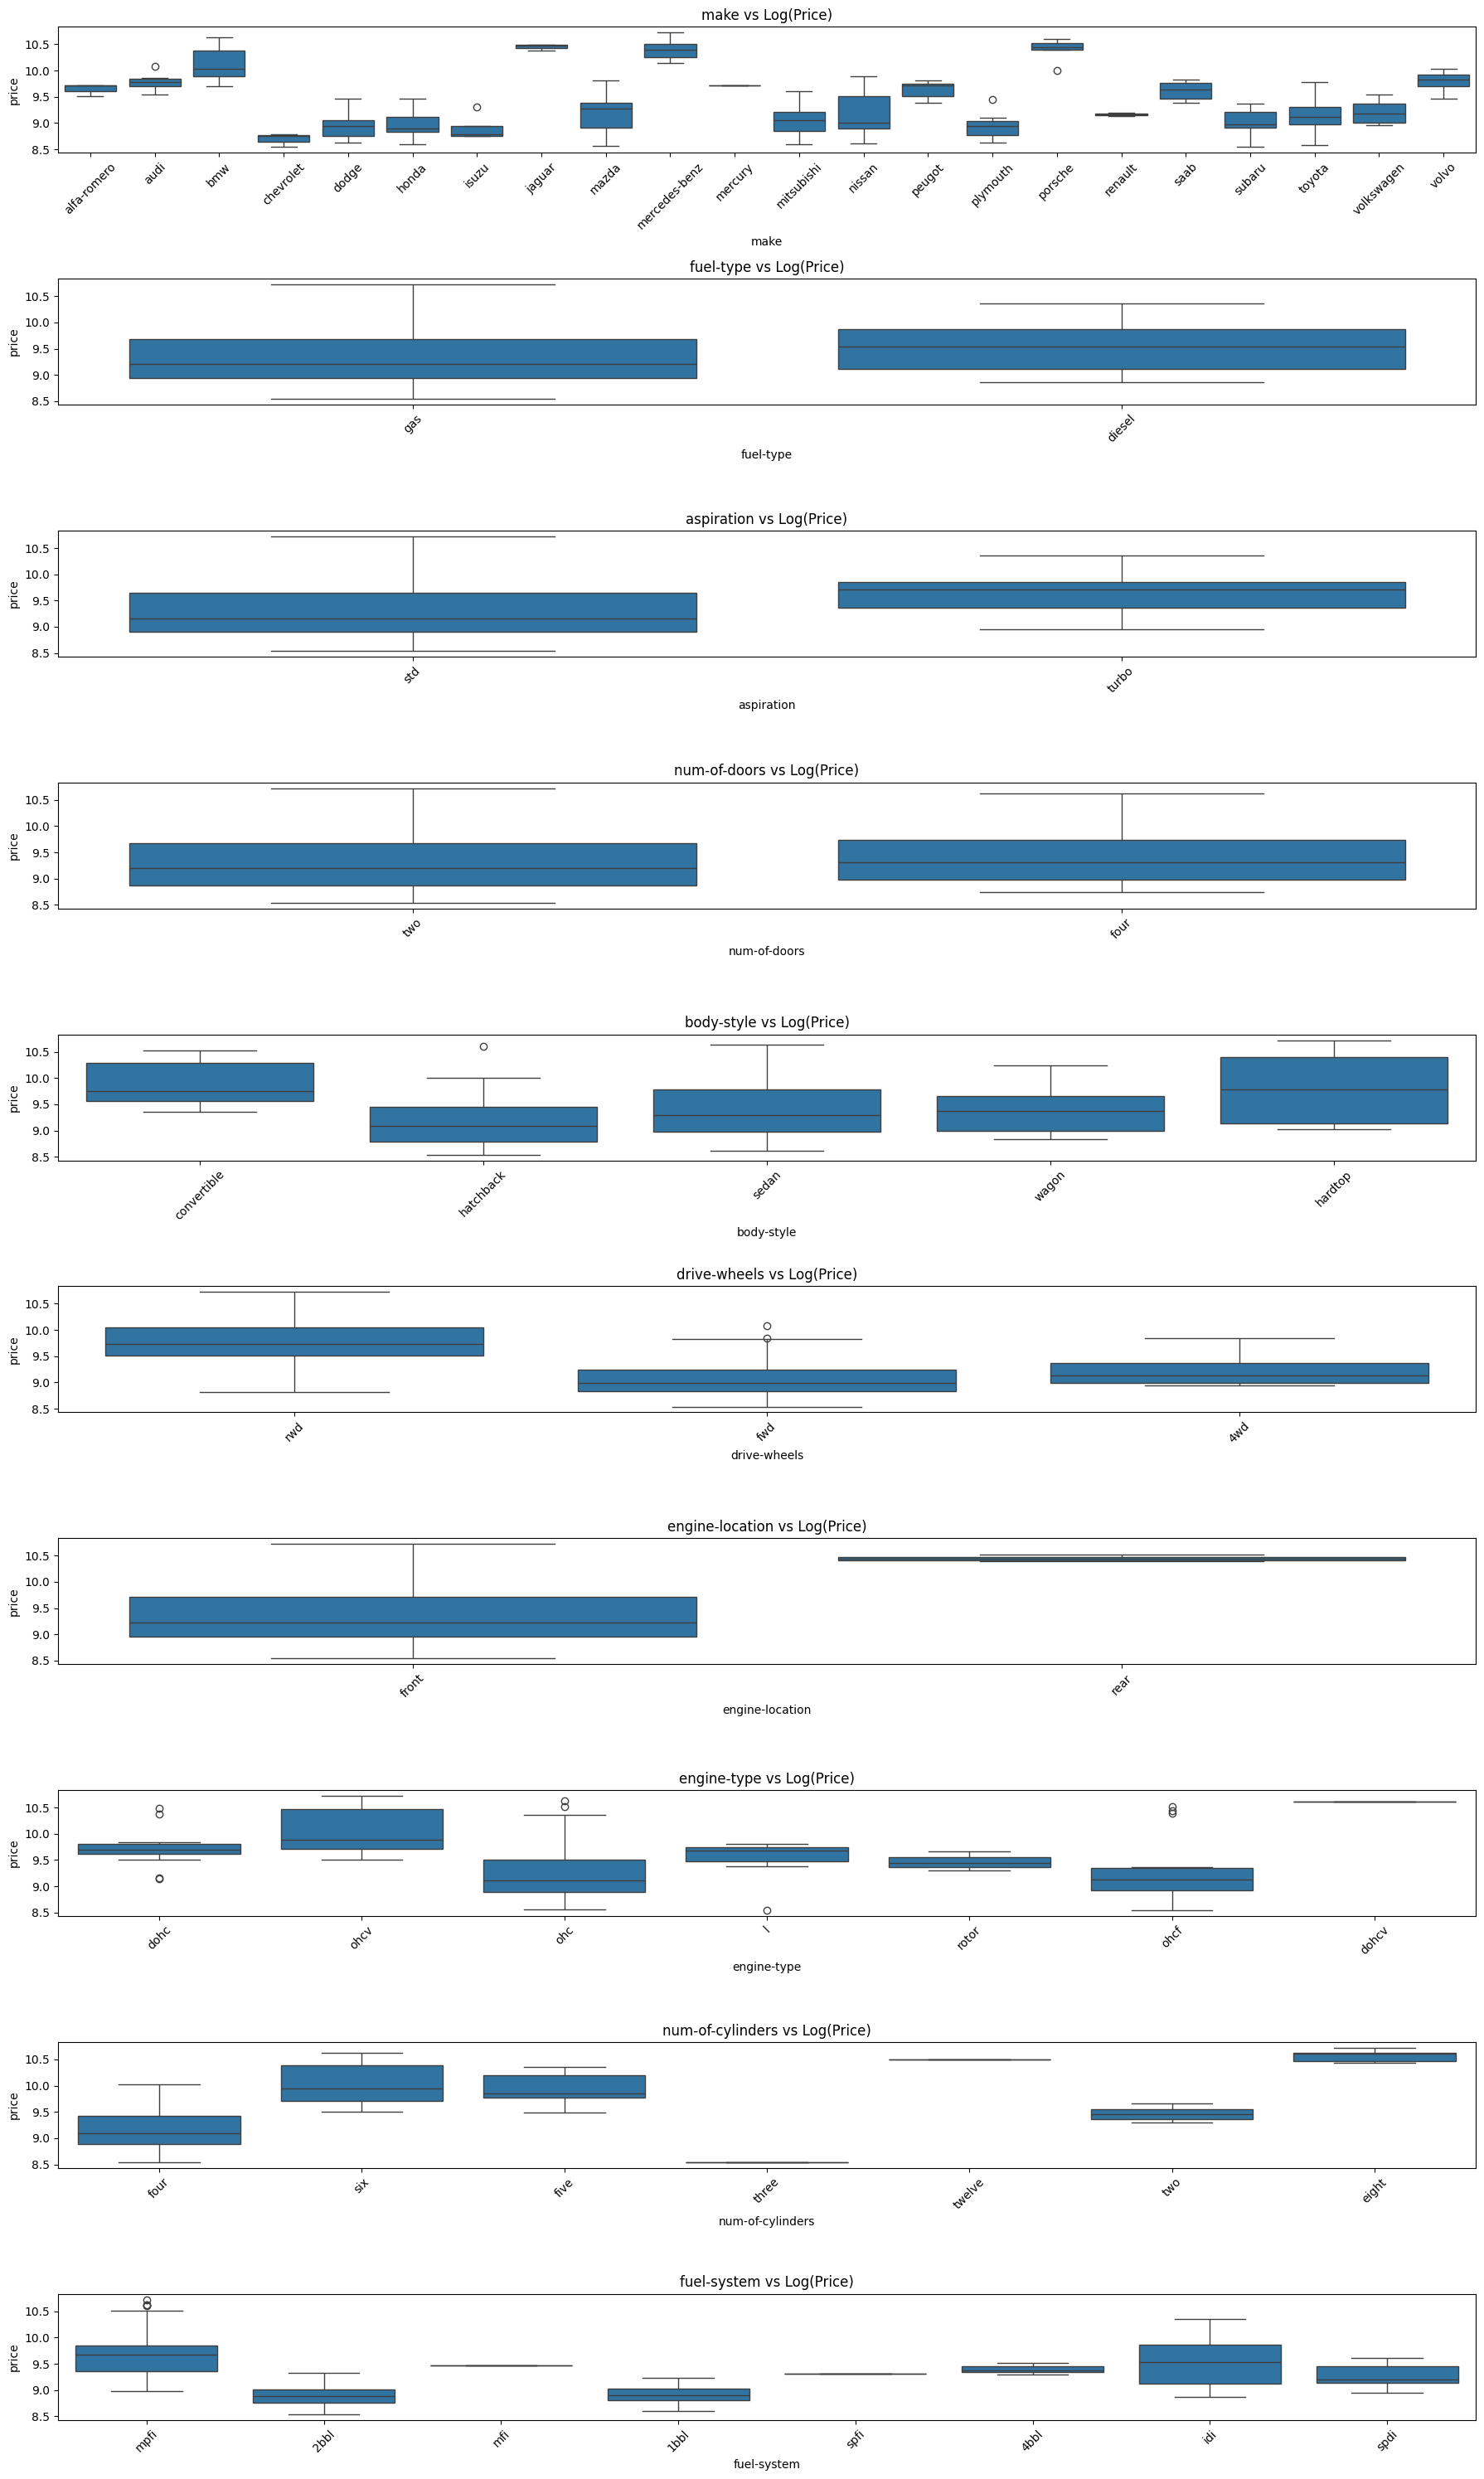

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify categorical features
categorical_cols = df.select_dtypes(include='object').columns.tolist()

plt.figure(figsize=(18, len(categorical_cols) * 3))

for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.boxplot(data=df, x=col, y='price')
    plt.xticks(rotation=45)
    plt.title(f'{col} vs Log(Price)')

plt.tight_layout()
plt.show()


In [147]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.1 MB/s eta 0:00:00


In [148]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

# Prepare X, y (handling categorical)
X_cat_encoded = pd.get_dummies(df.drop(columns=['price']), drop_first=True)
y = df['price']

# Fit a model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_cat_encoded, y)

# Run permutation importance
perm = PermutationImportance(model, random_state=42)
perm.fit(X_cat_encoded, y)

# Display results
eli5.show_weights(perm, feature_names=X_cat_encoded.columns.tolist())


Weight,Feature
0.5480 ± 0.0670,curb-weight
0.1921 ± 0.0385,engine-size
0.0490 ± 0.0060,highway-mpg
0.0162 ± 0.0015,normalized-losses
0.0118 ± 0.0028,width
0.0073 ± 0.0021,wheel-base
0.0064 ± 0.0010,horsepower_log
0.0061 ± 0.0015,horsepower
0.0045 ± 0.0007,length
0.0045 ± 0.0008,city-mpg


In [149]:
pip install shap


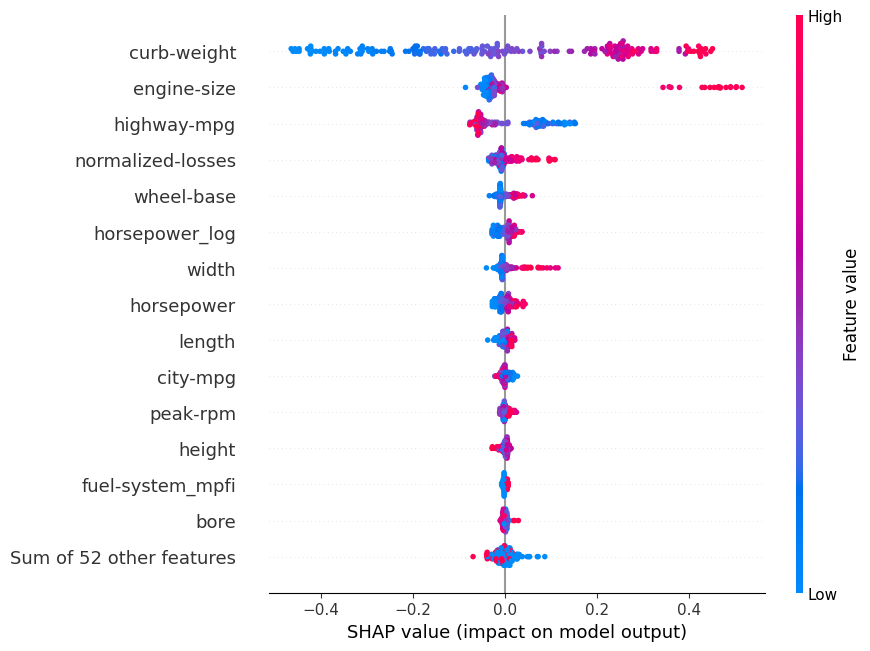

In [151]:
import shap

# Recreate X with proper one-hot encoding and remove object dtypes
X_cat_encoded = pd.get_dummies(df.drop(columns=['price']), drop_first=True)
X_cat_encoded = X_cat_encoded.astype(float)  # Cast to ensure all columns are numeric

y = df['price']

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_cat_encoded, y)
import shap

explainer = shap.Explainer(model, X_cat_encoded)  # Now should work
shap_values = explainer(X_cat_encoded)

# Visualize feature importance
shap.plots.beeswarm(shap_values, max_display=15)


In [ ]:
# In Short We select only those variable which are MODERATELY CORELATED with price and do NOT VIOLATE rules of MULTICOLINEARITY

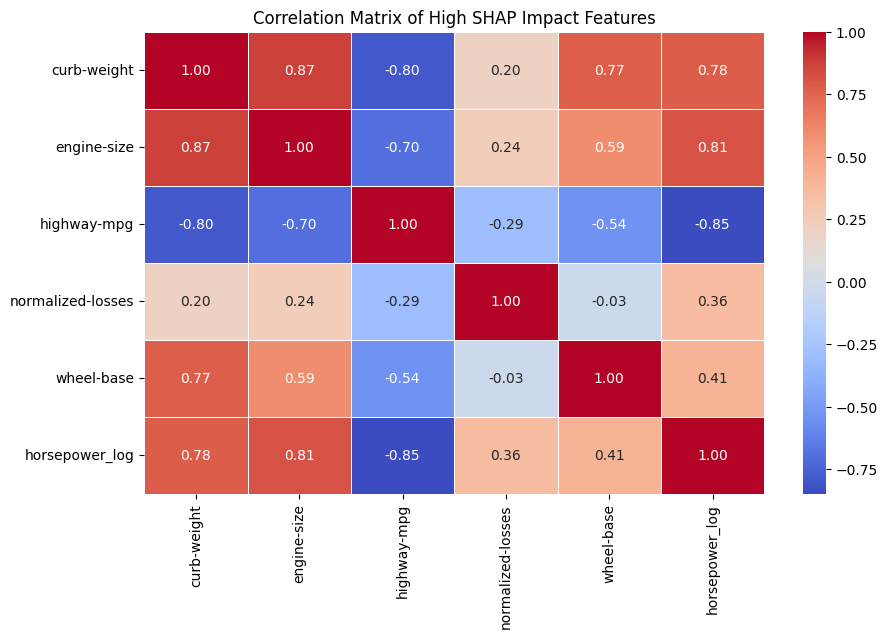

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top features
top_features = ['curb-weight', 'engine-size', 'highway-mpg', 'normalized-losses', 'wheel-base', 'horsepower_log']

# Compute correlation matrix
corr_matrix = df[top_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of High SHAP Impact Features')
plt.show()


In [154]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[top_features].dropna()
X = add_constant(X)
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


             feature           VIF
0              const  24367.291723
1        curb-weight     10.435653
2        engine-size      5.897873
3        highway-mpg      4.917219
4  normalized-losses      1.211176
5         wheel-base      3.444068
6     horsepower_log      6.660580


In [176]:
#merging high collinearlity columns thru PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

collinear_features = ['curb-weight', 'engine-size', 'horsepower_log']

scaler = StandardScaler()
scaled_cols = scaler.fit_transform(df[collinear_features])

pca = PCA(n_components=0.95)  # retain 95% variance
pca_features = pca.fit_transform(scaled_cols)

pca_df = pd.DataFrame(pca_features, columns=[f'pca_{i+1}' for i in range(pca_features.shape[1])])

df_reduced = df.drop(columns=collinear_features).reset_index(drop=True)
df_final = pd.concat([df_reduced, pca_df], axis=1)


In [177]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define target and features
X = df_final.drop(columns=['price'])  # or your actual target
y = df_final['price']

# Handle categorical variables if not already
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [178]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Fill NaNs just in case
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


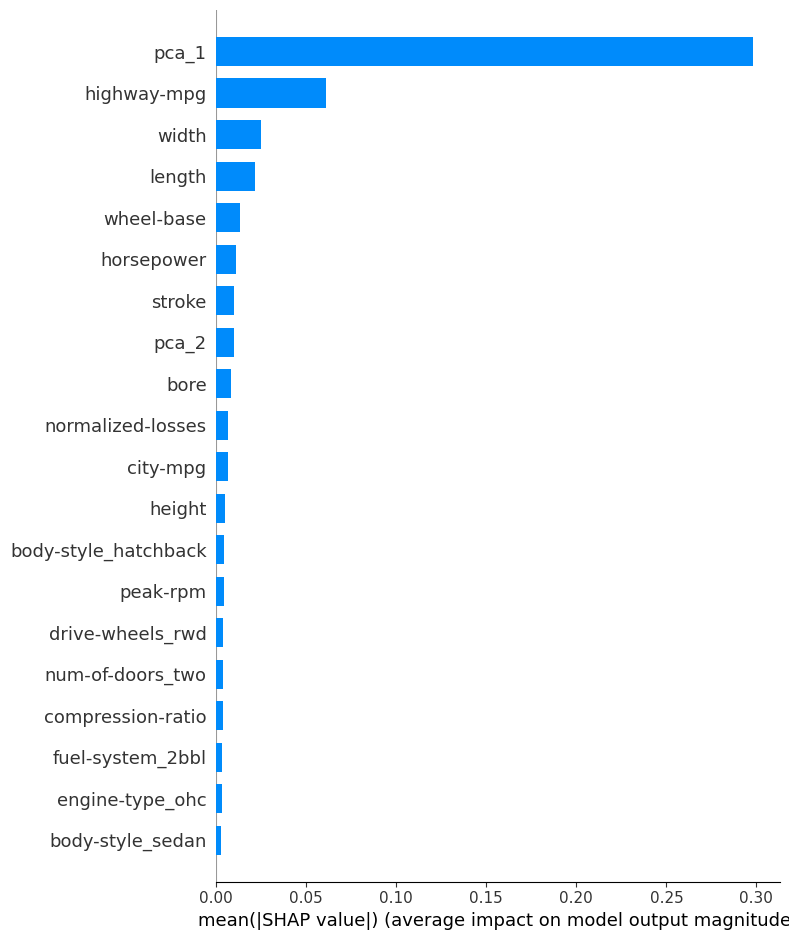

In [179]:
# Drop target first
X = df_final.drop(columns=['price'])
y = df_final['price']

# One-hot encode entire feature set (including PCA components if any)
X_encoded = pd.get_dummies(X, drop_first=True)

# Ensure all columns are numeric and handle any remaining non-numeric data
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        X_encoded[col] = pd.to_numeric(X_encoded[col], errors='coerce')

# Fill NaNs that might have been created by coercion
X_encoded.fillna(0, inplace=True)


# Assert that all columns are now numeric (optional, but good for verification)
assert all(X_encoded.dtypes != 'object'), "There are still object columns after conversion!"

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
import shap

# Fit model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Convert to NumPy array with float dtype before passing to SHAP
X_train_np = X_train.values.astype(float)
X_test_np = X_test.values.astype(float)

# SHAP explainer
explainer = shap.Explainer(model, X_train_np)
shap_values = explainer(X_test_np)

# Plot summary
shap.summary_plot(shap_values, X_test, plot_type="bar")

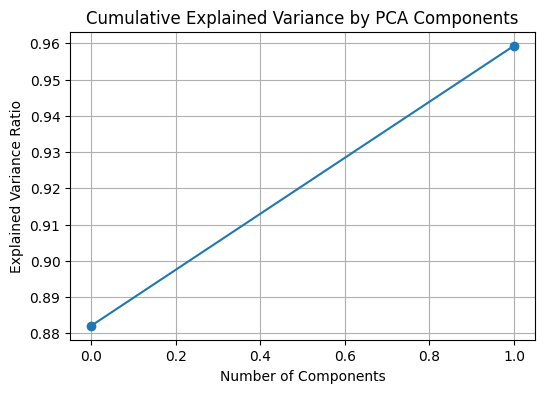

In [180]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()
